# DSCI 573: Feature and Model Selection 

## Lecture 7: Regularization

UBC Master of Data Science program, 2020-21

Instructor: Varada Kolhatkar 

In [1]:
import os

%matplotlib inline
import string
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import pandas as pd

# data
from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_extraction.text import CountVectorizer

# Feature selection
from sklearn.feature_selection import RFE, RFECV, SelectFromModel
from sklearn.impute import SimpleImputer

# classifiers / models
from sklearn.linear_model import (
    Lasso,
    LassoCV,
    LinearRegression,
    LogisticRegression,
    Ridge,
    RidgeCV,
)

# other
from sklearn.metrics import accuracy_score, log_loss, make_scorer, mean_squared_error
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    ShuffleSplit,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PolynomialFeatures,
    StandardScaler,
)
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier

pd.set_option("display.max_colwidth", 200)

### Learning outcomes 

From this lecture, students are expected to be able to: 

- Explain the general idea of L2 regularization.
- Explain the relation between the size of regression weights and overfitting. 
- Use L2 regularization (Ridge) using `sklearn`. 
- Explain the general idea of L1-regularization.
- Use L1-regularization (Lasso) using `sklearn`. 
- Discuss sparsity in L1-regularization. 
- Compare L0-, L1-, and L2-regularization.
- Use L1 regularization for feature selection. 
- Explain the importance of scaling when using L1- and L2-regularization
- Briefly explain how L1 and L2 regularization behave in the presence of collinear features.   

## 1. Motivation 
- Video 1


### Complex models and the fundamental tradeoff

- We’ve said that complex models tend to overfit more.
- Recall: polynomial degree and train vs. validation scores. 

Let's generate some synthetic data

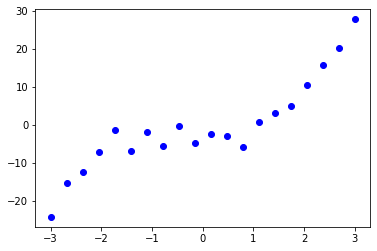

In [2]:
n = 20
X_train = np.linspace(-3, 3, n)
y_train = X_train ** 3 + npr.randn(n) * 3

n = 20
X_valid = np.linspace(-3, 3, n)
y_valid = X_valid ** 3 + npr.randn(n) * 3

# transforming the data to include another axis
X_train = X_train[:, np.newaxis]
y_train = y_train[:, np.newaxis]

X_valid = X_valid[:, np.newaxis]
y_valid = y_valid[:, np.newaxis]

plt.scatter(X_train, y_train, color="blue")

Let's fit polynomials of different degrees on the synthetic data. 

In [3]:
def plot_train_poly_deg():
    plt.figure(figsize=(16, 8))
    count = 1
    degrees = [0, 1, 2, 3, 10, 15, 16, 18]
    for deg in degrees:  # needs scikit-learn-0.20
        pipe_poly_lr = make_pipeline(PolynomialFeatures(degree=deg), LinearRegression())
        plt.subplot(2, 4, count)
        pipe_poly_lr.fit(X_train, y_train)
        plt.scatter(X_train, y_train, color="blue")
        plt.plot(X_train, pipe_poly_lr.predict(X_train), color="green", linewidth=3)
        plt.title(
            "p = %s, train = %0.3f" % (str(deg), pipe_poly_lr.score(X_train, y_train))
        )
        count += 1

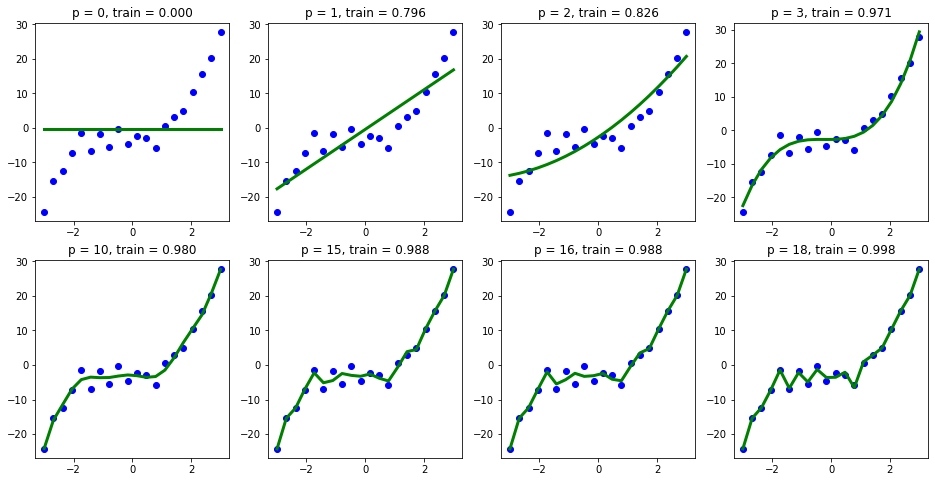

In [4]:
plot_train_poly_deg()

The training score goes up as we increase the degree of the polynomial, and is highest for $p = 18$.

- How good are these models on the validation set?
- The validation score is highest for $p = 3$, and it goes down as we increase the degree after that; we start overfitting after $p=3$.   

In [5]:
def plot_valid_poly_deg():
    plt.figure(figsize=(16, 8))
    count = 1
    degrees = [0, 1, 2, 3, 10, 15, 16, 18]
    for deg in degrees:  # needs scikit-learn-0.20
        pipe_poly_lr = make_pipeline(PolynomialFeatures(degree=deg), LinearRegression())
        plt.subplot(2, 4, count)
        pipe_poly_lr.fit(X_train, y_train)
        plt.scatter(X_valid, y_valid, color="blue")
        plt.plot(X_train, pipe_poly_lr.predict(X_train), color="green", linewidth=3)
        count += 1
        plt.title(
            "p = %s, valid = %0.3f" % (str(deg), pipe_poly_lr.score(X_valid, y_valid))
        )

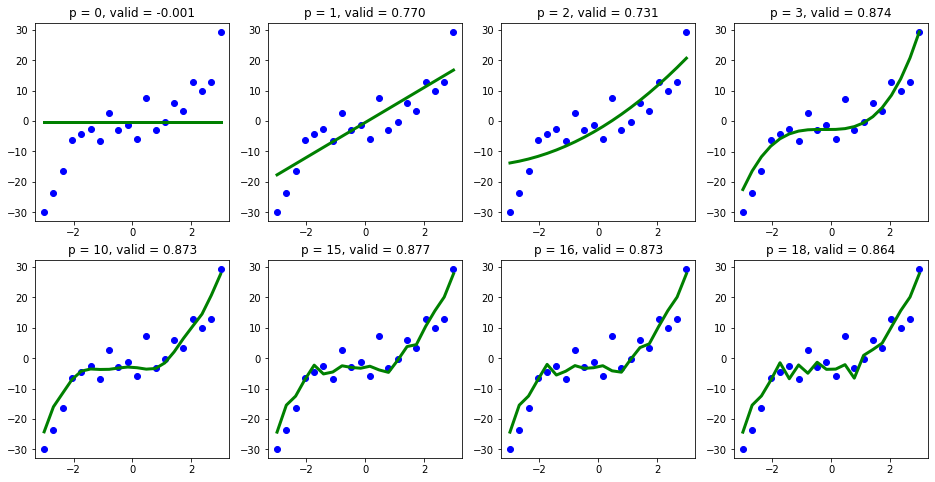

In [6]:
plot_valid_poly_deg()

- So there is a tradeoff between complexity of models and the validation score. 
- But what if we need complex models? 
- In supervised ML we try to find the mapping between $X$ and $y$, and usually the "true" mapping from $X$ to $y$ is complex.
    - Might need high-degree polynomial.
    - Might need to use many features, and don't know "relevant" ones.    

### Controlling model complexity

- Two methods to control complexity: 
    - Model averaging: average over multiple models to decrease variance (e.g., random forests). 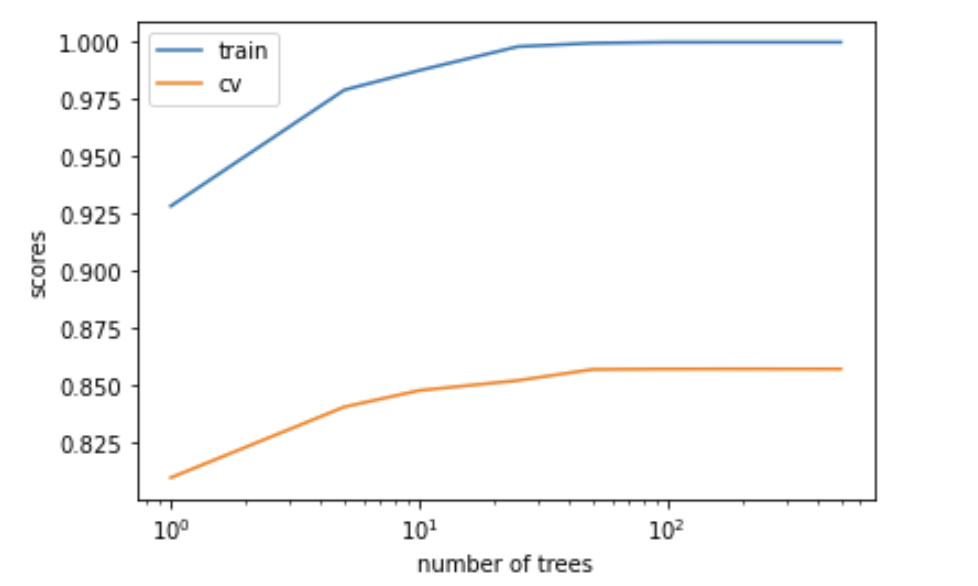
    
    - **Regularization: add a penalty on the complexity of the model**
        - This lecture!
        


### Idea of regularization: Pick the line/hyperplane with smaller slope 
<br>
<center>
<img src='imgs/green_or_red.png' width="600" height="600" />
</center>    

- Assuming red and green models have the same training score and if you are forced to choose one of them, which one would you pick?
    - **Pick green because its slope is smaller.**

### Why pick the line/hyperplane with smaller slope? 
<br>
<center>
<img src='imgs/green_or_red.png' width="500" height="500" />
</center>    

- Small change in $x_i$ has a smaller change in prediction $y_i$
- Green line's predictions are less sensitive to the training data. 
- Since green $w$ is less sensitive to training data, validation error might be lower. 

In this lecture we are going to explore methods to make $w$ less sensitive to the data.  

### Regularization: L0 penalty you have seen before

- Least squares loss before applying penalty: 

$$f(w) = \frac{1}{2}\sum_i^n(w^TX_i - y_i)^2 \text{ or }\\
f(x) = \frac{1}{2}\lVert{Xw -y}\rVert^2_2$$ 

- $\lVert{Xw -y}\rVert^2_2 \rightarrow$ square of the L2 norm $Xw -y$


### Regularization: L0 penalty you have seen before

- Least squares loss after applying L0 penalty: 

$$f(w) = \frac{1}{2}\lVert{Xw -y}\rVert^2_2 + \lambda \lVert w\rVert_0$$

- $\lVert{Xw -y}\rVert^2_2 \rightarrow$ square of the L2 norm $Xw -y$
- $\lambda \rightarrow$ penalty parameter
- $\lVert w\rVert_0 \rightarrow$  L0 norm of $w$      
    - The number of non-zero values in $w$.                
 

### Reminder: L0, L1, and L2 norms

### Terminology and notation: L0, L1, and L2 norms 

- L0 "norm" $\lVert w \rVert \rightarrow$ the number of non-zero elements in $w$  
- L1 norm $\lVert w \rVert_1 = \lvert w_1 \rvert + \lvert w_2 \rvert + \dots + \lvert w_n \rvert$ 
- L2 norm $\lVert w \rVert_2 = (w_1^2 + w_2^2 + \dots + w_n^2)^{1/2}$ 

In [7]:
from numpy import array
from numpy.linalg import norm

w = array([0, 2, 4])

l0 = norm(w, 0)  # number of non-zero values
l1 = norm(w, 1)  # sum of absolute values
l2 = norm(w, 2)  # square root of sum of the squared values
print("The l0 norm of %s is: %0.3f" % (w, l0))
print("The l1 norm of %s is: %0.3f" % (w, l1))
print("The l2 norm of %s is: %0.3f" % (w, l2))

The l0 norm of [0 2 4] is: 2.000
The l1 norm of [0 2 4] is: 6.000
The l2 norm of [0 2 4] is: 4.472


In [8]:
# norms of a vector
from numpy import array
from numpy.linalg import norm

w = array([1, -2, 3, 0])
# l0 norm is the number of non-zero values in a vector
print("The l0 norm of %s is: %0.3f" % (w, norm(w, 0)))

# l1 norm is the sum of the absolute values in a vector.
print("The l1 norm of %s is: %0.3f" % (w, norm(w, 1)))

# l2 norm is square root of the sum of the squared values in a vector.
print("The l2 norm of %s is: %0.3f" % (w, norm(w, 2)))

The l0 norm of [ 1 -2  3  0] is: 3.000
The l1 norm of [ 1 -2  3  0] is: 6.000
The l2 norm of [ 1 -2  3  0] is: 3.742


## 2. L2 regularization 

- Video 2

### L2 penalty 

- Standard regularization strategy is L2 regularization
    - We incorporate L2 penalty in the loss function $f(w)$: 
$$f(w) = \frac{1}{2}\sum_i^n(w^TX_i - y_i)^2 + \frac{\lambda}{2}\sum_j^d w_j^2 \text{ or }$$ 
$$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \frac{\lambda}{2} \lVert w\rVert_2^2$$

- $\lVert Xw - y\rVert_2^2 \rightarrow$ square of the $L2$ norm of $Xw -y$
- $\lambda \rightarrow$ regularization strength    
- $\lVert w\rVert_2^2 \rightarrow$  square of the L2 norm of $w$      
    - sum of the squared weight values.        

        


### L2 regularization 

$$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \frac{\lambda}{2} \lVert w\rVert_2^2$$

- Objective balances getting low error vs. having small slopes $w_j$
- In terms of fundamental trade-off:
    - You can increase the training error. 
    - Nearly-always reduces overfitting and the validation error.    

### Have we seen this before? 

- [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html): Linear Regression with L2 regularization 

> class sklearn.linear_model.Ridge(alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, tol=0.001, solver='auto', random_state=None)

> Linear least squares with l2 regularization. Minimizes the objective function: ||y - Xw||^2_2 + alpha * ||w||^2_2
This model solves a regression model where the loss function is the linear least squares function and regularization is given by the l2-norm. Also known as Ridge Regression or Tikhonov regularization.

- Uses the hyperparameter $\alpha$ for regularization strength instead of $\lambda$; larger value of $\alpha$ means more regularization.
$$f(w) = \lVert Xw - y\rVert_2^2 + \alpha \lVert w\rVert_2^2$$
 

- [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html): Logistic Regression with L2 regularization 

> class sklearn.linear_model.LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)

- `C`: default=1.0
Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization. 

### Size of regression weights and overfitting

- Bigger values of weights means the model is very sensitive to the training data. 
- Let's use Ridge with no regularization on polynomials with different degrees.

In [9]:
alpha = 0
degrees = [1, 2, 4, 6, 15, 20]
data = {}
for deg in degrees:
    pipe_poly_ridge = make_pipeline(
        PolynomialFeatures(degree=deg, include_bias=False), Ridge(alpha=alpha)
    )
    pipe_poly_ridge.fit(X_train, y_train)

    data.setdefault("degree", []).append(str(deg))
    data.setdefault("train_score", []).append(
        str(round(pipe_poly_ridge.score(X_train, y_train), 3))
    )
    data.setdefault("valid_score", []).append(
        str(round(pipe_poly_ridge.score(X_valid, y_valid), 3))
    )
    data.setdefault("weights", []).append(
        [round(i, 3) for i in list(pipe_poly_ridge.named_steps["ridge"].coef_[0])]
    )

/Users/kvarada/opt/miniconda3/envs/571/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.65967e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [10]:
pd.DataFrame(data)

,degree,train_score,valid_score,weights
0,1,0.796,0.77,[5.743]
1,2,0.826,0.731,"[5.743, 0.688]"
2,4,0.977,0.872,"[0.069, 1.806, 0.954, -0.132]"
3,6,0.977,0.871,"[-0.235, 1.737, 1.099, -0.111, -0.013, -0.002]"
4,15,0.988,0.877,"[2.65, -3.544, -23.958, 4.97, 42.755, -1.932, -28.846, 0.378, 9.49, -0.043, -1.621, 0.003, 0.138, -0.0, -0.005]"
5,20,1.0,0.85,"[9.922, -55.976, -114.727, 542.503, 351.067, -1679.367, -478.091, 2333.862, 347.236, -1705.769, -144.523, 708.765, 35.294, -172.262, -4.966, 24.104, 0.371, -1.79, -0.011, 0.054]"


- When we fit a higher degree polynomial, some weights are large.  
- So for higher degree polynomials, the model would be very sensitive to the data. 

### Size of regression weights and overfitting

- The idea of regularization is to "regularize" weights so that they are small and so less sensitive to the data. 
- Let's try adding regularization with a bigger value of `alpha`. 

In [11]:
alpha = 100
degrees = [1, 2, 4, 6, 15, 20]
data = {}
for deg in degrees:
    pipe_poly_ridge = make_pipeline(
        PolynomialFeatures(degree=deg, include_bias=False), Ridge(alpha=alpha)
    )
    pipe_poly_ridge.fit(X_train, y_train)

    data.setdefault("degree", []).append(str(deg))
    data.setdefault("train_score", []).append(
        str(round(pipe_poly_ridge.score(X_train, y_train), 3))
    )
    data.setdefault("valid_score", []).append(
        str(round(pipe_poly_ridge.score(X_valid, y_valid), 3))
    )
    data.setdefault("weights", []).append(
        [round(i, 3) for i in list(pipe_poly_ridge.named_steps["ridge"].coef_[0])]
    )

/Users/kvarada/opt/miniconda3/envs/571/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.55354e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


In [12]:
pd.DataFrame(data)

,degree,train_score,valid_score,weights
0,1,0.508,0.467,[2.29]
1,2,0.534,0.448,"[2.29, 0.437]"
2,4,0.964,0.879,"[0.124, 0.222, 0.913, 0.04]"
3,6,0.966,0.87,"[0.183, 0.114, 0.534, 0.265, 0.05, -0.025]"
4,15,0.977,0.875,"[0.058, 0.032, 0.097, 0.069, 0.119, 0.106, 0.086, 0.089, -0.016, -0.048, -0.0, 0.007, 0.0, -0.0, -0.0]"
5,20,0.979,0.87,"[0.05, 0.013, 0.087, 0.024, 0.115, 0.031, 0.109, 0.036, 0.04, 0.036, -0.05, 0.02, 0.015, -0.025, -0.002, 0.007, 0.0, -0.001, -0.0, 0.0]"


- If we "regularize" the weights for a complex model e.g., $p = 20$ the weights are small
- It means that we are less sensitive to the data.

### Why are small weights better? 
- Suppose $x_1$ and $x_2$ are nearby each other. 
- We might expect that they have similar $\hat{y}$. 
- If we change feature1 value by a small amount $\epsilon$ in $x_2$, leaving everything else the same, we might think that the prediction would be the same.
- But if we have bigger weights small change in $x_2$ has a large effect on the prediction. 

In [13]:
x_1 = np.array([1, 1, 0, 1, 1, 0])
x_2 = np.array([0.8, 1, 0, 1, 1, 0])
weights = np.array([100, 0.1, 1, 0.22, 4, 3])

print("x_1 prediction: ", x_1.dot(weights))
print("x_2 prediction: ", x_2.dot(weights))

x_1 prediction:  104.32
x_2 prediction:  84.32


### Why are small weights better? 
- In linear models, the rate of change of the prediction function is proportional to the individual weights. 
- So if we want the function to change slowly, we want to ensure that the weights stay small.
- The idea is to avoid putting all our energy into one features, which might give us over-confident predictions and lead to overfitting. 

### How `alpha` affects the weights 

Let's try different values of alpha and look at the weights.

In [14]:
deg = 10
alphas = 10.0 ** np.arange(-4, 4)
data = {}
for alpha in alphas:
    pipe_poly_ridge = make_pipeline(
        PolynomialFeatures(degree=deg, include_bias=False), Ridge(alpha=alpha)
    )
    pipe_poly_ridge.fit(X_train, y_train)

    data.setdefault("alpha", []).append(str(alpha))
    data.setdefault("train_score", []).append(
        str(round(pipe_poly_ridge.score(X_train, y_train), 3))
    )
    data.setdefault("valid_score", []).append(
        str(round(pipe_poly_ridge.score(X_valid, y_valid), 3))
    )
    data.setdefault("weights", []).append(
        [round(i, 3) for i in list(pipe_poly_ridge.named_steps["ridge"].coef_[0])]
    )

In [15]:
pd.DataFrame(data)

,alpha,train_score,valid_score,weights
0,0.0001,0.98,0.873,"[-0.722, -2.847, 1.487, 3.789, -0.069, -1.175, -0.003, 0.145, 0.001, -0.006]"
1,0.001,0.98,0.873,"[-0.719, -2.824, 1.483, 3.77, -0.067, -1.169, -0.003, 0.144, 0.001, -0.006]"
2,0.01,0.98,0.873,"[-0.689, -2.608, 1.444, 3.589, -0.053, -1.115, -0.005, 0.137, 0.001, -0.006]"
3,0.1,0.98,0.873,"[-0.47, -1.353, 1.161, 2.529, 0.053, -0.792, -0.02, 0.097, 0.001, -0.004]"
4,1.0,0.979,0.874,"[-0.007, 0.205, 0.539, 1.07, 0.288, -0.323, -0.054, 0.036, 0.003, -0.001]"
5,10.0,0.977,0.875,"[0.11, 0.248, 0.285, 0.399, 0.382, -0.011, -0.066, -0.012, 0.004, 0.001]"
6,100.0,0.974,0.872,"[0.076, 0.06, 0.182, 0.122, 0.309, 0.127, -0.039, -0.032, 0.002, 0.002]"
7,1000.0,0.957,0.855,"[0.022, 0.015, 0.053, 0.042, 0.1, 0.073, 0.027, -0.014, -0.003, 0.001]"


- We also observe the fundamental tradeoff. 
- As we increase `alpha` the weights become smaller and smaller. 
- We see that the rounded values of some weights are close to zero. 

### L2-Regularization "Shrinking" Example

<center>
<img src='imgs/l2_shrinking_example.png' width="700" height="700" />
</center>    

- We get least squares with $\lambda = 0$.
- But we can achieve similar training error with smaller $\lVert w\rVert^2$.
- $\lVert Xw - y\rVert^2$ increases with $\lambda$, and $\lVert w\rVert^2$ decreases with λ.
    - Though individual $w_j$ can increase or decrease with lambda because we use the L2-norm, the large ones decrease the most.

### `alpha` values and fit of the model 

- Let's examine the effect of different alpha values on the fit of a polynomial with degree 10. 

In [16]:
def plot_alpha_train_score():
    plt.figure(figsize=(16, 8))
    count = 1
    alphas = 10.0 ** np.arange(-4, 4)
    degree = 10
    for alpha in alphas:  # needs scikit-learn-0.20
        pipe_poly_lr = make_pipeline(PolynomialFeatures(degree=deg), Ridge(alpha=alpha))
        plt.subplot(2, 4, count)
        pipe_poly_lr.fit(X_train, y_train)
        preds = pipe_poly_lr.predict(X_train)
        plt.scatter(X_train, y_train, color="blue")
        plt.plot(X_train, preds, color="green", linewidth=3)
        plt.title(
            "alpha = %s, train = %0.3f"
            % (str(alpha), pipe_poly_lr.score(X_train, y_train))
        )
        count += 1

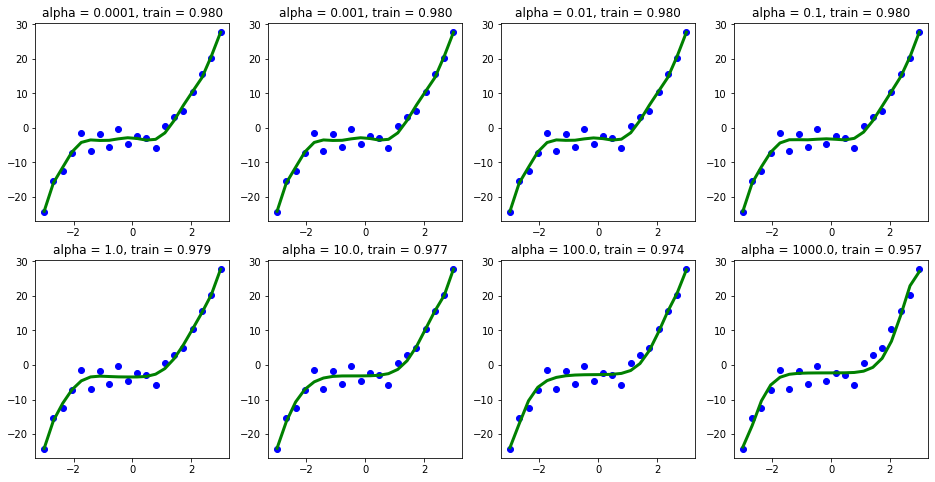

In [17]:
plot_alpha_train_score()

- Strong regularization means we our complex model becomes smoother.  

### The weights become smaller but never become zero

In [18]:
deg = 10
pipe_poly_ridge = make_pipeline(
    PolynomialFeatures(degree=deg, include_bias=False), Ridge(alpha=1000)
)
pipe_poly_ridge.fit(X_train, y_train)
threshold = 1e-6
coeffs = pipe_poly_ridge.named_steps["ridge"].coef_
normalized_weights = np.abs(coeffs[0]) / np.max(np.abs(coeffs[0]))
print("Features with non-zero values: ", np.where(normalized_weights > threshold)[0])

Features with non-zero values:  [0 1 2 3 4 5 6 7 8 9]


- That said, they won't have much impact on prediction. 
- Strong regularization means the results are not too sensitive to the training data. 
- We are keeping the complexity of the model but making it less sensitive to the feature values! 

### Regularization path

- Weights shrink and converge to zero as $\lambda$ grows but they do not become exactly 0. 

- Imagine that $w_j = 0.000001$. The penalty for this $w_j$ is $0.000000000001$, i.e., a very tiny number. So there is less incentive to decrease the loss. The incentive (slope) is smaller and smaller as we approach 0 and therefore the coefficients do not become exactly 0.  

<img src='imgs/regularization_path.png' width="700" height="700" />

### Question: L0 versus L2 regularization (solution)

- Imagine the following two weight vectors which give the same validation errors. 
$$w^1 = \begin{bmatrix}100 \\0\end{bmatrix}  w^2 = \begin{bmatrix}99.98 \\0.03\end{bmatrix}$$  

- Which one would be chosen by L0 regularization? 
    - $\lVert w^1\rVert_0 = 1$ and $\lVert w^2\rVert_0 = 2$. So it will pick $w^1$
- Which one would be chosen by L2 regularization? 
    - L2 regularizer focuses on decreasing the largest weight smaller. 
    - $99.98^2 + 0.03^2 = 9996.0013$ < $100^2 = 10000$

### How to pick $\lambda$? 

- Theory: as $n$ grows $\lambda$ should be in the range $O(1)$ to $\sqrt{n}$.
- Practice: optimize validation set or cross-validation error.
    - Almost always decreases the test error.

### Should we regularize the y-intercept?

- No! 
    - Why encourage it to be closer to zero? (It could be anywhere.)
    - You should be allowed to shift function up/down globally.
- Yes! 
    - Useful for optimization; It makes the solution unique and it easier to compute $w$    
- Compromise: regularize by a smaller amount than other variables.
    $$f(w) = \lVert Xw + w_0 - y\rVert^2 + \frac{\lambda_1}{2}\lVert w\rVert^2 + \frac{\lambda_2}{2}w_0^2$$  

### Some properties of L2 regularization

1. Solution $w$ is unique. (We are not going into mathematical details.)
2. Almost always improves the validation error. 
3. No collinearity issues.
4. Less sensitive to changes in $X$.
5. Gradient descent converges faster (bigger $\lambda$ means fewer iterations). (You'll learn about Grafient descent in 572.)
6. Worst case: just set $\lambda$ small and get the same performance

### Interim summary: L2 regularization 

- Change the loss function by adding a continuous penalty on the model complexity. 
- Best parameter $\lambda$ almost already leads to improved validation error.
    - L2-regularized least squares is also called "ridge regression". 
    - Can be solved as a linear system like least squares.
- Some benefits of L2 regularization  
    - Solution is unique.
    - Less sensitive to data.
    - Fast. 

### 3. L1 regularization
- Video 3 

### L1-regularization 

$$f(w) = \frac{1}{2}\sum_i^n(w^TX_i - y_i)^2 + \frac{\lambda}{2}\sum_j^d \lvert w_j \lvert\text{ or }$$ 
$$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \frac{\lambda}{2} \lVert w\rVert_1$$


- $\lambda \rightarrow$ regularization strength
- $\lVert w\rVert_1 \rightarrow$  L1 norm of $w$  
- Objective balances getting low error vs. having small values for $w_j$


### Similarities with L2-regularization

- L1-regularization 
$$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \frac{\lambda}{2} \lVert w\rVert_1$$

- L2-regularization 
$$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \frac{\lambda}{2} \lVert w\rVert_2^2$$

- Both shrink weights.
- Both result in lower validation error. 

### Terminology and notation: Ridge and Lasso

- Linear regression model that uses L2 regularization is called **Ridge** or Tikhonov regularization.
    - [`scikit-learn` Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html?highlight=ridge#sklearn.linear_model.Ridge)
- Linear regression model that uses L1 regularization is called **Lasso**. 
    - [`scikit-learn` Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html?highlight=lasso)
    > class sklearn.linear_model.Lasso(alpha=1.0, fit_intercept=True, normalize=False, precompute=False, copy_X=True, max_iter=1000, tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')



- Let's use `Lasso` with different values of `alpha`. 

In [19]:
deg = 10
alphas = 10.0 ** np.arange(-4, 4)
data = {}
for alpha in alphas:
    pipe_poly_lasso = make_pipeline(
        PolynomialFeatures(degree=deg, include_bias=False),
        Lasso(alpha=alpha, max_iter=1000),
    )
    pipe_poly_lasso.fit(X_train, y_train)

    data.setdefault("alpha", []).append(str(alpha))
    data.setdefault("train_score", []).append(
        str(round(pipe_poly_lasso.score(X_train, y_train), 3))
    )
    data.setdefault("valid_score", []).append(
        str(round(pipe_poly_lasso.score(X_valid, y_valid), 3))
    )
    data.setdefault("weights", []).append(
        [round(i, 3) for i in list(pipe_poly_lasso.named_steps["lasso"].coef_)]
    )

/Users/kvarada/opt/miniconda3/envs/571/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.391529929329604, tolerance: 0.27492167016359675
  model = cd_fast.enet_coordinate_descent(
/Users/kvarada/opt/miniconda3/envs/571/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.41861102626206, tolerance: 0.27492167016359675
  model = cd_fast.enet_coordinate_descent(
/Users/kvarada/opt/miniconda3/envs/571/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 30.686729958362754, tolerance: 0.27492167016359675
  model = cd_fast.enet_coordinate_descent(
/Users/kvarada/opt/miniconda3

In [20]:
pd.DataFrame(data)

,alpha,train_score,valid_score,weights
0,0.0001,0.978,0.873,"[-0.428, 1.632, 1.288, -0.019, -0.045, -0.018, -0.001, 0.0, 0.0, 0.0]"
1,0.001,0.978,0.873,"[-0.418, 1.623, 1.282, -0.016, -0.044, -0.018, -0.001, 0.0, 0.0, 0.0]"
2,0.01,0.978,0.873,"[-0.313, 1.547, 1.218, 0.013, -0.034, -0.022, -0.001, 0.0, 0.0, 0.0]"
3,0.1,0.978,0.874,"[-0.0, 1.058, 1.004, 0.159, 0.001, -0.033, -0.002, -0.0, 0.0, 0.0]"
4,1.0,0.972,0.867,"[0.0, 0.0, 0.434, 0.288, 0.148, -0.006, -0.008, -0.005, -0.0, 0.0]"
5,10.0,0.951,0.853,"[0.0, 0.0, 0.0, 0.0, 0.131, 0.024, 0.019, 0.001, -0.002, -0.0]"
6,100.0,0.922,0.85,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.041, 0.004, -0.003, -0.0]"
7,1000.0,0.764,0.756,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.002, 0.0]"


- Smaller `alpha` values have higher weights 
- Larger `alpha` values results in smaller weights. 
- Many weights become zero. 

### The weights become smaller and smaller and become zero

In [21]:
deg = 10
pipe_poly_lasso = make_pipeline(
    PolynomialFeatures(degree=deg, include_bias=False), Lasso(alpha=100)
)
pipe_poly_lasso.fit(X_train, y_train)
threshold = 1e-6
coeffs = pipe_poly_lasso.named_steps["lasso"].coef_
normalized_weights = np.abs(coeffs) / np.max(np.abs(coeffs))
print("Features with non-zero values: ", np.where(normalized_weights > threshold)[0])

Features with non-zero values:  [6 7 8 9]


- It has assigned zero weight to many features!! 
- Sparsity! 

### Terminology and notation: Sparsity 

- We say a linear function is sparse if most of the coefficients are zero. 
- Example: Here only 2 out of 8 coefficients are non-zero and so it is a sparse function. 
$$0x_1 + 0.45 x_2 + 0  x_3 + 0x_4 + 1.2x_5 + 0x_6 + 0x_7 + 0x_8$$

### Similarities between L1- and L0-regularization 

- Like L0-norm, it encourages elements of $w$ to be exactly zero.
- L1-regularization simultaneously regularizes and selects features.
- Very fast alternative to search and score (L0 penalty).
    - With L0 penalty, we had to 
- L1-regularization 
$$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \frac{\lambda}{2} \lVert w\rVert_1$$

- L0-regularization 
$$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \frac{\lambda}{2} \lVert w\rVert_0$$


### Example: L0 vs. L1 vs. L2

Consider problem where 3 vectors can get minimum training error:

$$w^1 = \begin{bmatrix}100 \\0.02\end{bmatrix},  w^2 = \begin{bmatrix}100 \\0\end{bmatrix}, w^3 = \begin{bmatrix}99.99 \\0.02\end{bmatrix}$$ 

- Without regularization, we could choose any of these 3.
- They all have same error, so regularization will "break tie".
- Which one would you choose with each of L0, L1, L2 regularization?

### Which one would you choose with L0 regularization? 

$$w^1 = \begin{bmatrix}100 \\-0.02\end{bmatrix},  w^2 = \begin{bmatrix}100 \\0\end{bmatrix}, w^3 = \begin{bmatrix}99.99 \\0.02\end{bmatrix}$$ 

- With L0 regularization, you would choose $w^2$
    - $\lVert w^1\rVert_0 = 2$
    - $\lVert w^2\rVert_0 = 1$
    - $\lVert w^3\rVert_0 = 2$

### Which one would you choose with L1 regularization? 

$$w^1 = \begin{bmatrix}100 \\0.02\end{bmatrix},  w^2 = \begin{bmatrix}100 \\0\end{bmatrix}, w^3 = \begin{bmatrix}99.99 \\0.02\end{bmatrix}$$ 

- With L1 regularization, you would choose $w^2$. 
    - $\lVert w^1\rVert_1 = 100.02$
    - $\lVert w^2\rVert_1 = 100$
    - $\lVert w^3\rVert_1 = 100.01$
- L1-regularization focuses on decreasing all $w_j$ until they are 0. 

### Which one would you choose with L2 regularization? 

$$w^1 = \begin{bmatrix}100 \\0.02\end{bmatrix},  w^2 = \begin{bmatrix}100 \\0\end{bmatrix}, w^3 = \begin{bmatrix}99.99 \\0.02\end{bmatrix}$$ 

- With L1 regularization, you would choose $w^3$. 
    - $\lVert w^1\rVert_2^2 = (100)^2 + (0.02)^2 = 10000.0004$
    - $\lVert w^2\rVert_2^2 = (100)^2 = 10000$
    - $\lVert w^3\rVert_2^2 = (99.99)^2 + (0.02)^2 = 9998.0005$
    
- L2-regularization focuses on decreasing largest $w_j$ smaller    

### (Optional) Sparsity and Regularization

<img src='imgs/regularization_paths.png' width="1000" height="1000" />

### (optional) Sparsity and Regularization (with d=1) 

<img src='imgs/sparsity_regularization.png' width="1000" height="1000" />

### Some properties of L1 regularization

1. Almost always improves the validation error. 
2. Can learn with exponential number of irrelevant features.
3. Less sensitive to changes in $X$.
4. The solution is not unique. (If interested in more explanation on this, see slide 43 in [this slide deck](https://www.cs.ubc.ca/~schmidtm/Courses/340-F19/L18.pdf).)

### L1 for feature selection

- We used L0 regularization in search and score methods for feature selection.  
- Can we use L1 regularization for feature selection because it has sparsity?

## 4. Feature selection using L1 regularization 
- Video 4 

### Feature selection methods so far

- Feature selection methods we have seen so far: 
    - RFE
    - Search and score with L0-regularization (e.g., forward search)
- An effective way of feature selection: L1-regularization 

In [22]:
from sklearn.datasets import load_boston, load_breast_cancer

boston_housing = load_boston()
#print(boston_housing.keys())
#print(boston_housing.DESCR)

In [23]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation
    """
    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [24]:
boston_df = pd.DataFrame(boston_housing.data, columns=boston_housing.feature_names)
boston_df["target"] = boston_housing.target
train_df, test_df = train_test_split(boston_df, test_size=0.2, random_state=2)

X_train, y_train = train_df.drop(columns=["target"]), train_df["target"]
X_test, y_test = test_df.drop(columns=["target"]), test_df["target"]

In [25]:
results = {}

In [26]:
from sklearn.preprocessing import PolynomialFeatures

pipe_rfe_ridgecv = make_pipeline(
    StandardScaler(), PolynomialFeatures(), RFECV(Ridge(), cv=10), RidgeCV()
)

In [27]:
results["RFE Ridge"] = mean_std_cross_val_scores(
    pipe_rfe_ridgecv, X_train, y_train, return_train_score=True
)
pd.DataFrame(results)

,RFE Ridge
fit_time,1.264 (+/- 0.056)
score_time,0.002 (+/- 0.000)
test_score,0.802 (+/- 0.088)
train_score,0.907 (+/- 0.035)


Let's use L1 regularization as feature selection. 

In [28]:
from sklearn.feature_selection import SelectFromModel

pipe_l1_ridgecv = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    SelectFromModel(LassoCV(max_iter=2000)),
    RidgeCV(),
)

In [29]:
results["L1 regularization"] = mean_std_cross_val_scores(
    pipe_l1_ridgecv, X_train, y_train, return_train_score=True
)
pd.DataFrame(results)

/Users/kvarada/opt/miniconda3/envs/571/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:525: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7431972571173446, tolerance: 1.7210772403100776
  model = cd_fast.enet_coordinate_descent_gram(


,RFE Ridge,L1 regularization
fit_time,1.264 (+/- 0.056),0.425 (+/- 0.066)
score_time,0.002 (+/- 0.000),0.002 (+/- 0.000)
test_score,0.802 (+/- 0.088),0.815 (+/- 0.078)
train_score,0.907 (+/- 0.035),0.919 (+/- 0.014)


Let's look at the coefficients. 

In [30]:
pipe_l1_ridgecv.fit(X_train, y_train)
pipe_l1_ridgecv.named_steps["selectfrommodel"].estimator_.coef_

array([ 0.        , -0.        ,  0.        ,  0.63569027,  0.        ,
       -0.98689837,  3.55026179, -1.31082485, -2.66589432,  0.4751201 ,
       -0.        , -0.59087554,  1.12418015, -3.07261127,  0.10195516,
       -0.        , -0.        ,  5.2006241 , -0.20699814,  0.40540676,
       -0.        , -0.        , -0.47615371,  0.        , -0.        ,
       -0.10305434,  0.433369  ,  0.09021728, -0.31918278, -0.07189749,
       -0.        , -0.0297253 , -0.13775129, -0.2564756 , -0.        ,
        1.41504546, -0.13596046,  0.        , -0.25713116,  0.70304396,
        0.        ,  2.41947452,  0.76452374,  0.18993168,  0.89252337,
       -0.        ,  0.01543774, -0.14731665,  0.        , -1.07087586,
        0.46877825, -1.0369579 , -0.72879662,  0.20370078,  0.        ,
       -0.33684991,  0.        , -0.19279016,  0.0940002 , -0.32156006,
       -0.66742211, -0.17325393, -0.72401858,  1.58968674, -0.80785825,
        0.        , -0.87047052,  0.        ,  0.76079265,  0.08

In [31]:
pipe_l1_ridgecv.named_steps["selectfrommodel"].threshold_

1e-05

How many features were passed to the final model? 

In [32]:
print(
    "The number of features after polynomial transformation: ",
    pipe_l1_ridgecv.named_steps["polynomialfeatures"].n_output_features_,
)
print(
    "The number of features passed to the final model: ",
    len(pipe_l1_ridgecv.named_steps["ridgecv"].coef_),
)

The number of features after polynomial transformation:  105
The number of features passed to the final model:  77


### Our usual game of getting feature names for the coefficients

In [33]:
(
    np.abs(pipe_l1_ridgecv.named_steps["selectfrommodel"].estimator_.coef_)
    > pipe_l1_ridgecv.named_steps["selectfrommodel"].threshold_
)

array([False, False, False,  True, False,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True, False, False,  True,
        True,  True, False, False,  True, False, False,  True,  True,
        True,  True,  True, False,  True,  True,  True, False,  True,
        True, False,  True,  True, False,  True,  True,  True,  True,
       False,  True,  True, False,  True,  True,  True,  True,  True,
       False,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True, False,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True, False,  True,  True,
       False,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True, False, False,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [34]:
poly_feature_names = pipe_l1_ridgecv.named_steps[
    "polynomialfeatures"
].get_feature_names()  # transformed list to array
support = (
    np.abs(pipe_l1_ridgecv.named_steps["selectfrommodel"].estimator_.coef_)
    > pipe_l1_ridgecv.named_steps["selectfrommodel"].threshold_
)
l1_selected_feats = np.array(poly_feature_names)[support]
l1_selected_feats

array(['x2', 'x4', 'x5', 'x6', 'x7', 'x8', 'x10', 'x11', 'x12', 'x0^2',
       'x0 x3', 'x0 x4', 'x0 x5', 'x0 x8', 'x0 x11', 'x0 x12', 'x1^2',
       'x1 x2', 'x1 x3', 'x1 x5', 'x1 x6', 'x1 x7', 'x1 x9', 'x1 x10',
       'x1 x12', 'x2^2', 'x2 x4', 'x2 x5', 'x2 x6', 'x2 x7', 'x2 x9',
       'x2 x10', 'x2 x12', 'x3^2', 'x3 x4', 'x3 x5', 'x3 x6', 'x3 x8',
       'x3 x10', 'x3 x11', 'x3 x12', 'x4^2', 'x4 x5', 'x4 x6', 'x4 x7',
       'x4 x8', 'x4 x10', 'x4 x12', 'x5^2', 'x5 x6', 'x5 x8', 'x5 x9',
       'x5 x10', 'x5 x11', 'x5 x12', 'x6^2', 'x6 x8', 'x6 x9', 'x6 x11',
       'x6 x12', 'x7^2', 'x7 x8', 'x7 x9', 'x7 x11', 'x7 x12', 'x8^2',
       'x8 x9', 'x8 x12', 'x9 x10', 'x9 x11', 'x9 x12', 'x10^2',
       'x10 x11', 'x10 x12', 'x11^2', 'x11 x12', 'x12^2'], dtype='<U7')

In [35]:
coef_df = pd.DataFrame(
    data=pipe_l1_ridgecv.named_steps["ridgecv"].coef_,
    index=l1_selected_feats,
    columns=["Coefficient"],
)
coef_df

,Coefficient
x2,1.464352
x4,-1.013904
x5,3.604779
x6,-1.601881
x7,-2.430137
...,...
x10 x11,0.065983
x10 x12,0.269627
x11^2,-0.305546
x11 x12,-0.287693


Note: Although L2 regularization doesn't make coefficients zero, you can still use it for feature selection using `SelectFromModel` with a threshold. See documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html). 

### Regularized logistic regression

- Regularization is not limited to least squares. 
- We can add L1 and L2 penalty terms in other loss functions as well. 
- Let's look at logistic regression with L1 and L2 regularization.

In [42]:
from sklearn.datasets import load_breast_cancer

breast_cancer = load_breast_cancer()
#print(breast_cancer.keys())
#print(breast_cancer.DESCR)

In [43]:
breast_cancer_df = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
breast_cancer_df["target"] = breast_cancer.target
train_df, test_df = train_test_split(breast_cancer_df, test_size=0.2, random_state=2)

X_train, y_train = train_df.drop(columns=["target"]), train_df["target"]
X_test, y_test = test_df.drop(columns=["target"]), test_df["target"]

In [44]:
X_train.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
560,14.05,27.15,91.38,600.4,0.09929,0.11260,0.04462,0.04304,0.1537,0.06171,...,15.30,33.17,100.20,706.7,0.1241,0.22640,0.1326,0.10480,0.2250,0.08321
428,11.13,16.62,70.47,381.1,0.08151,0.03834,0.01369,0.01370,0.1511,0.06148,...,11.68,20.29,74.35,421.1,0.1030,0.06219,0.0458,0.04044,0.2383,0.07083
198,19.18,22.49,127.50,1148.0,0.08523,0.14280,0.11140,0.06772,0.1767,0.05529,...,23.36,32.06,166.40,1688.0,0.1322,0.56010,0.3865,0.17080,0.3193,0.09221
203,13.81,23.75,91.56,597.8,0.13230,0.17680,0.15580,0.09176,0.2251,0.07421,...,19.20,41.85,128.50,1153.0,0.2226,0.52090,0.4646,0.20130,0.4432,0.10860
41,10.95,21.35,71.90,371.1,0.12270,0.12180,0.10440,0.05669,0.1895,0.06870,...,12.84,35.34,87.22,514.0,0.1909,0.26980,0.4023,0.14240,0.2964,0.09606


In [45]:
y_train.value_counts(normalize=True)

1    0.632967
0    0.367033
Name: target, dtype: float64

In [46]:
from sklearn.metrics import f1_score, recall_score, make_scorer

custom_scorer = make_scorer(f1_score, pos_label=0)
scoring_metric = custom_scorer

results_classification = {}

Let's try `DummyClassifier`

In [47]:
dummy = DummyClassifier()
results_classification["dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True, scoring=scoring_metric, 
)
pd.DataFrame(results_classification)

/Users/kvarada/opt/miniconda3/envs/571/lib/python3.8/site-packages/sklearn/dummy.py:131: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  warnings.warn("The default value of strategy will change from "


,dummy
fit_time,0.001 (+/- 0.001)
score_time,0.001 (+/- 0.001)
test_score,0.324 (+/- 0.102)
train_score,0.356 (+/- 0.018)


### Logistic regression with regularization

- In `sklearn`, by default logistic regression uses L2 regularization. 

In [48]:
pipe_lgr_l2 = make_pipeline(StandardScaler(), LogisticRegression())
results_classification["Logistic Regression L2"] = mean_std_cross_val_scores(
    pipe_lgr_l2, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

In [49]:
pd.DataFrame(results_classification)

,dummy,Logistic Regression L2
fit_time,0.001 (+/- 0.001),0.012 (+/- 0.003)
score_time,0.001 (+/- 0.001),0.002 (+/- 0.000)
test_score,0.324 (+/- 0.102),0.970 (+/- 0.011)
train_score,0.356 (+/- 0.018),0.985 (+/- 0.005)


All coefficients are non-zero. 

In [51]:
pipe_lgr_l2.fit(X_train, y_train)
pipe_lgr_l2.named_steps["logisticregression"].coef_

array([[-0.53985391, -0.25214061, -0.49456043, -0.61045146, -0.17406619,
         0.57798312, -0.65877728, -0.98024393,  0.11997381,  0.40647904,
        -1.24795634, -0.10325774, -0.73120148, -0.93158422, -0.23099107,
         0.61431692, -0.03231823, -0.20637638,  0.27288293,  0.73956073,
        -1.04015025, -1.09620691, -0.88548864, -1.02686306, -0.92729009,
        -0.07540269, -0.76656759, -0.73296575, -0.66992505, -0.52093938]])

Let's try logistic regression with L1 regularization 

In [52]:
pipe_lgr_l1 = make_pipeline(
    StandardScaler(), LogisticRegression(solver="liblinear", penalty="l1")
)
results_classification["Logistic Regression L1"] = mean_std_cross_val_scores(
    pipe_lgr_l1, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

In [53]:
pd.DataFrame(results_classification)

,dummy,Logistic Regression L2,Logistic Regression L1
fit_time,0.001 (+/- 0.001),0.012 (+/- 0.003),0.005 (+/- 0.000)
score_time,0.001 (+/- 0.001),0.002 (+/- 0.000),0.002 (+/- 0.000)
test_score,0.324 (+/- 0.102),0.970 (+/- 0.011),0.967 (+/- 0.007)
train_score,0.356 (+/- 0.018),0.985 (+/- 0.005),0.984 (+/- 0.006)


- The scores are more or less the same.
- But L1 regularization is carrying out feature selection. 
- Many coefficients are 0. 

In [54]:
pipe_lgr_l1.fit(X_train, y_train)
pipe_lgr_l1.named_steps["logisticregression"].coef_

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -1.34879417,  0.        ,  0.26748365,
        -2.02931667,  0.        ,  0.        ,  0.        , -0.12686138,
         0.55076679,  0.        ,  0.        ,  0.        ,  0.21862455,
        -1.65562392, -1.37553893, -0.29633874, -3.44417943, -0.98542359,
         0.        , -1.03509447, -0.63533194, -0.29819291,  0.        ]])

We can also carry out feature selection using L1 regularization and pass selected features to another model. 

In [55]:
from lightgbm.sklearn import LGBMClassifier
pipe_lgr_lgbm = make_pipeline(
    StandardScaler(),
    SelectFromModel(LogisticRegression(solver="liblinear", penalty="l1")),
    LGBMClassifier(),
)

In [56]:
results_classification["L1 + LGBM"] = mean_std_cross_val_scores(
    pipe_lgr_lgbm,
    X_train,
    y_train,
    return_train_score=True,
    scoring=scoring_metric,
)
pd.DataFrame(results_classification)

,dummy,Logistic Regression L2,Logistic Regression L1,L1 + LGBM
fit_time,0.001 (+/- 0.001),0.012 (+/- 0.003),0.005 (+/- 0.000),0.039 (+/- 0.009)
score_time,0.001 (+/- 0.001),0.002 (+/- 0.000),0.002 (+/- 0.000),0.003 (+/- 0.000)
test_score,0.324 (+/- 0.102),0.970 (+/- 0.011),0.967 (+/- 0.007),0.961 (+/- 0.037)
train_score,0.356 (+/- 0.018),0.985 (+/- 0.005),0.984 (+/- 0.006),1.000 (+/- 0.000)


- The score went down in this case. But this might help in some other cases.
- The resulting model is using L1 selected features only. 

## 5. Regularization: scaling and colinearity 

- Video 5 

### Regularization and scaling 

- It doesn't matter for decision trees or naive Bayes.
    - They only look at one feature at a time.
- It doesn't matter for least squares:
    - $w_j*(100 mL)$ gives the same model as $w_j*(0.1 L)$ with a different $w_j$
- It matters for $k$-nearest neighbours:
    - Distance will be affected more by large features than small features.
- **It matters for regularized least squares**:
    - Penalizing $w_j^2$ means different things if features $j$ are on different scales
    - Penalizing $w_j$ means different things if features $j$ are on different scales
    

## Scaling features

We've seen cases where scaling the features is important to get good performance. We can test this out:

#### Normalizing [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
> normalize: bool, optional, default False
This parameter is ignored when fit_intercept is set to False. If True, the regressors X will be normalized before regression by subtracting the mean and dividing by the l2-norm. If you wish to standardize, please use sklearn.preprocessing.StandardScaler before calling fit on an estimator with normalize=False.

In [68]:
from sklearn.datasets import make_regression
n_samples = 100
n_features = 10

X, y = make_regression(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=10,
    noise=0.50,
    random_state=111,
)
### make the first feature on a huge scale
X[:, 0] = X[:, 0] * 1000
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=111
)

Let's check whether the linear regression model is different when we normalize vs. when we do not normalize


In [69]:
lr = LinearRegression(normalize=False)
lr.fit(X_train, y_train)

lr_scale = LinearRegression(normalize=True)
lr_scale.fit(X_train, y_train)

np.allclose(lr.predict(X_test), lr_scale.predict(X_test))

True

Let's check whether the Ridge model is different when we normalize vs. when we do not normalize


In [70]:
ridge = Ridge(normalize=False)
ridge.fit(X_train, y_train)

ridge_scale = Ridge(normalize=True)
ridge_scale.fit(X_train, y_train)

np.allclose(ridge.predict(X_test), ridge_scale.predict(X_test))

False

Let's check whether the Lasso model is different when we normalize vs. when we do not normalize

In [71]:
lasso = Lasso(normalize=False)
lasso.fit(X_train, y_train)

lasso_scale = Lasso(normalize=True)
lasso_scale.fit(X_train, y_train)

np.allclose(lasso.predict(X_test), lasso_scale.predict(X_test))

False

### Scaling: summary

- Un-regularized linear regression: not affected by scaling
- L1 or L2-regularized linear regression: both affected by scaling (and it's usually a good idea)

### Collinearity and regularization 

- If you have colinear features, the weights would go crazy with regular linear regression. 
- With L2 regularization: The weight will be equally distributed among all collinear features because the solution is unique. 
    - Example: suppose we have three identical features with a total weight of 1 
    - The weight will be distributed as 1/3, 1/3, 1/3 among the features. 
- With L1 regularization: The weight will not be equally distributed; the solution is not unique. 
    - Example: suppose we have three identical features with a total weight of 1 
    - The weight could be distributed in many different ways 
    - For example, 1/2, 1/4, 1/4 or 1.0, 0, 0 or 1/2, 1/2, 0 and so on ...

### Elastic nets

- Combine good properties from both worlds

$$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \lambda(\alpha\lVert w\rVert_1 + (1-\alpha)\lVert w\rVert_2^2 )  $$

- $\lambda$ control the strength of regularization 
- $\alpha$ controls the amount of sparsity and smoothness
- L1 promotes sparsity and the L2 promotes smoothness.
- The functional is strictly convex: the solution is unique.
- No collinearity problem 
    - A whole group of correlated variables is selected rather than just one variable in the group.

You can use elastic nets using sklearn's [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html). 

### How to use regularization with `scikit-learn`: some examples

- Regression
    - Least squares with L2-regularization: [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)
    - Least squares with L1-regularization: [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)
    - Least squares with L1- and L2-regularization: [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)
    - [SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html?highlight=svr#sklearn.svm.SVR) ($\epsilon$-insensitive loss function)
        - `epsilon = 0` gives us `KernelRidge` model (least squares with RBF)
- Classification 
    - [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) (supports L2-regularization)
    - [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) (support L1 and L2 with different solvers)
    > penalty{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’ Used to specify the norm used in the penalization. The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties. ‘elasticnet’ is only supported by the ‘saga’ solver. If ‘none’ (not supported by the liblinear solver), no regularization is applied.



#### Summary: L* regularization 

- L0-regularization (AIC, BIC, Mallow’s Cp, Adjusted R2, ANOVA):
   - Adds penalty on the number of non-zeros to select features.

$$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \lambda\lVert w\rVert_0$$    


- L2-regularization (ridge regression):
    - Adding penalty on the L2-norm of $w$ to decrease overfitting:
$$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \frac{\lambda}{2} \lVert w\rVert_2^2$$    

- L1-regularization (lasso regression):
    - Adding penalty on the L1-norm decreases overfitting and selects features:
$$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \frac{\lambda}{2} \lVert w\rVert_1$$            

#### Summary: L* regularization 
<br>

<img src='imgs/regularization_summary.png' width="1000" height="1000" />

- "Elastic net" (L1- and L2-regularization) is sparse, fast, and unique.

### True/False questions: L2-regularization

1. Introducing L2 regularization to the model means making it less sensitive to changes in $X$. (True)
2. Introducing L2 regularization to the model can results in worse performance on the training set. (True)
3. Imagine that you fit linear regression twice with different values of $\lambda$, $\lambda = 0$ and $\lambda=10$. You are given the weights learned from two different models below. Without knowing which weights came from which model, you can guess that $w^1$ probably corresponds to $\lambda = 10$ and $w^2$ probably corresponds to $\lambda = 0$. (False. Using higher $\lambda$ is likely to result in lower weights.)
$$w^1 = \begin{bmatrix} 32.43\\23.14\\16.4\end{bmatrix} \text{ and }w^2 = \begin{bmatrix} 2.03\\1.2\\0.4\end{bmatrix}$$ 

4. L2 regularization shrinks the weights but all $w_j$s tend to be non-zero. (True)
5. In L2 regularization, as $\lambda$ increases, $\lVert Xw –y\rVert_2^2$ decreases and $\lVert w\rVert_2^2$ increases. (False)

$$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \frac{\lambda}{2} \lVert w\rVert_2^2$$
<br><br><br><br><br><br><br><br><br>

### True/False questions: L1-regularization

1. Both L0- and L1-regularization give sparsity but L2-regularization doesn't. (True)
2. In L1-regularization, larger $\lambda$ selects few features and smaller $\lambda$ allows many features. (True)
$$f(w) = \frac{1}{2}\lVert Xw - y\rVert_2^2 + \frac{\lambda}{2} \lVert w\rVert_1$$
3. L1-regularization tends to be a better choice than L2 regularization in most cases. (False. It's context dependent.)
4. Both L1- and L2-regularization shrink weights. (True)

<br><br><br><br><br><br><br><br><br>
